## Modelo de Clasificación para la compra

Este notebook incluye los siguientes pasos:

* Cargar el conjunto de datos
* Preprocesamiento de funciones
* Definir el modelo
* Construye la tubería
* Evaluar el modelo
* Ajuste de hiperparámetros
* Realizacion predicciones y evaluacion el rendimiento del modelo

In [0]:
# File location and type
file_location = "/FileStore/tables/venta.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df.limit(5))

User ID,Genero,Edad,Salario,Compra
15624510,Male,19,19000,0
15810944,Male,35,20000,0
15668575,Female,26,43000,0
15603246,Female,27,57000,0
15804002,Male,19,76000,0


In [0]:
df.columns

Out[2]: ['User ID', 'Genero', 'Edad', 'Salario', 'Compra']

In [0]:
# Create a view or table

temp_table_name = "venta_csv"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select * from `venta_csv` limit 5

User ID,Genero,Edad,Salario,Compra
15624510,Male,19,19000,0
15810944,Male,35,20000,0
15668575,Female,26,43000,0
15603246,Female,27,57000,0
15804002,Male,19,76000,0


## Dividimos el dataset en Train y Test

In [0]:
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())

342
58


In [0]:
display(trainDF.limit(5))

User ID,Genero,Edad,Salario,Compra
15566689,Female,35,57000,0
15569641,Female,58,95000,1
15570932,Male,34,115000,0
15571059,Female,33,41000,0
15573452,Female,21,16000,0


In [0]:
display(trainDF
        .groupBy("Genero")
        .count()
        .sort("count", ascending=False))

Genero,count
Female,174
Male,168


## Transformadores, estimadores y tuberías

Tres conceptos importantes en el aprendizaje automático de MLlib que se ilustran en este notebook son **Transformers**, **estimadores** y **Pipelines**.

- **Transformer**: Toma un DataFrame como entrada y devuelve un nuevo DataFrame. Los transformadores no aprenden ningún parámetro de los datos y simplemente aplican transformaciones basadas en reglas para preparar los datos para el entrenamiento del modelo o generar predicciones usando un modelo MLlib entrenado. Llamas a un transformador con un método `.transform ()`.

- **Estimador**: aprende los parámetros del DataFrame a través de un método `.fit ()` y devuelve un modelo, que es un transformador.

- **Pipeline**: combina varios pasos en un solo flujo de trabajo que se puede ejecutar fácilmente. La creación de un modelo de aprendizaje automático generalmente implica configurar muchos pasos diferentes e iterar sobre ellos. Los pipelines  ayudan a automatizar este proceso.

## Convertimos la variable categorica en numerica

In [0]:
df.columns

Out[12]: ['User ID', 'Genero', 'Edad', 'Salario', 'Compra']

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = ["Genero"]

# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]) 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 


In [0]:
stringIndexerModel = stringIndexer.fit(trainDF)
display(stringIndexerModel.transform(trainDF.limit(5)))

User ID,Genero,Edad,Salario,Compra,GeneroIndex
15566689,Female,35,57000,0,0.0
15569641,Female,58,95000,1,0.0
15570932,Male,34,115000,0,1.0
15571059,Female,33,41000,0,0.0
15573452,Female,21,16000,0,0.0


## Combina todas las columnas de características en un solo vector de características

In [0]:
from pyspark.ml.feature import VectorAssembler

# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
numericCols = ["Salario", "Edad"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

## Aplicamos el modelo de regresión Logística

In [0]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="Compra", regParam=1.0)

## Construimos la canalización con Pipeline

In [0]:
from pyspark.ml import Pipeline

# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder,vecAssembler, lr])

# Define the pipeline model.
pipelineModel = pipeline.fit(trainDF)
 
# Apply the pipeline model to the test dataset.
predDF = pipelineModel.transform(testDF)

In [0]:
display(predDF.limit(5))

User ID,Genero,Edad,Salario,Compra,GeneroIndex,GeneroOHE,features,rawPrediction,probability,prediction
15570769,Female,26,80000,0,0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 80000.0, 26.0))","Map(vectorType -> dense, length -> 2, values -> List(0.7976763850114337, -0.7976763850114337))","Map(vectorType -> dense, length -> 2, values -> List(0.6894772180686981, 0.3105227819313019))",0.0
15573926,Male,40,71000,1,1.0,"Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> dense, length -> 3, values -> List(0.0, 71000.0, 40.0))","Map(vectorType -> dense, length -> 2, values -> List(0.524229613913215, -0.524229613913215))","Map(vectorType -> dense, length -> 2, values -> List(0.628136258436915, 0.371863741563085))",0.0
15574372,Female,58,47000,1,0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 47000.0, 58.0))","Map(vectorType -> dense, length -> 2, values -> List(0.1941311867100608, -0.1941311867100608))","Map(vectorType -> dense, length -> 2, values -> List(0.5483809479635257, 0.45161905203647434))",0.0
15577178,Female,22,63000,0,0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 63000.0, 22.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9532339093203595, -0.9532339093203595))","Map(vectorType -> dense, length -> 2, values -> List(0.7217650780227889, 0.2782349219772111))",0.0
15579781,Female,29,47000,0,0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 3, values -> List(1.0, 47000.0, 29.0))","Map(vectorType -> dense, length -> 2, values -> List(0.8545103783168935, -0.8545103783168935))","Map(vectorType -> dense, length -> 2, values -> List(0.7015124405079024, 0.2984875594920976))",0.0


In [0]:
display(predDF.select("features","Compra", "prediction", "probability").limit(5))

features,Compra,prediction,probability
"Map(vectorType -> dense, length -> 3, values -> List(1.0, 80000.0, 26.0))",0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.6894772180686981, 0.3105227819313019))"
"Map(vectorType -> dense, length -> 3, values -> List(0.0, 71000.0, 40.0))",1,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.628136258436915, 0.371863741563085))"
"Map(vectorType -> dense, length -> 3, values -> List(1.0, 47000.0, 58.0))",1,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.5483809479635257, 0.45161905203647434))"
"Map(vectorType -> dense, length -> 3, values -> List(1.0, 63000.0, 22.0))",0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.7217650780227889, 0.2782349219772111))"
"Map(vectorType -> dense, length -> 3, values -> List(1.0, 47000.0, 29.0))",0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.7015124405079024, 0.2984875594920976))"


## Evaluando el Modelo

In [0]:
pipelineModel.stages[-1] ## el modelo de regresion logistica

Out[22]: LogisticRegressionModel: uid=LogisticRegression_5b7583b814d9, numClasses=2, numFeatures=3

In [0]:
display(pipelineModel.stages[-1], predDF.drop("prediction", "rawPrediction", "probability"), "ROC")

False Positive Rate,True Positive Rate,Threshold
0.0,0.0,0.5452471659354148
0.0,0.05263157894736842,0.5452471659354148
0.0,0.10526315789473684,0.51307767360717
0.0,0.15789473684210525,0.5035866161255694
0.02564102564102564,0.15789473684210525,0.48084168320278164
0.02564102564102564,0.21052631578947367,0.4770603477436657
0.02564102564102564,0.2631578947368421,0.46860794830680674
0.02564102564102564,0.3157894736842105,0.45817588028444944
0.02564102564102564,0.3684210526315789,0.4562978523185728
0.02564102564102564,0.42105263157894735,0.45161905203647434


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC",labelCol="Compra")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")

mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy",labelCol="Compra")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.932523616734143
Accuracy: 0.7241379310344828


## Ajuste de Hiperparametros

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

In [0]:
# Create a 3-fold CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=bcEvaluator, numFolds=3, parallelism = 4)

# Run cross validations. This step takes a few minutes and returns the best model found from the cross validation.
cvModel = cv.fit(trainDF)

## Realizamos nuevas predicciones y evaluamos el modelo

In [0]:
# Use the model identified by the cross-validation to make predictions on the test dataset
cvPredDF = cvModel.transform(testDF)

# Evaluate the model's performance based on area under the ROC curve and accuracy 
print(f"Area under ROC curve: {bcEvaluator.evaluate(cvPredDF)}")
print(f"Accuracy: {mcEvaluator.evaluate(cvPredDF)}")

Area under ROC curve: 0.9338731443994601
Accuracy: 0.8793103448275862


## Utilizamos otra metrica, para evaluar el modelo, La matriz de confusion

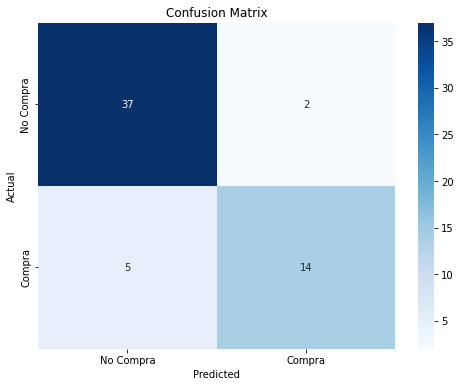

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = cvModel.transform(testDF)

y_true = predictions.select("Compra").collect()
y_pred = predictions.select("prediction").collect()

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Compra", "Compra"], yticklabels=["No Compra", "Compra"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [0]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        39
           1       0.88      0.74      0.80        19

    accuracy                           0.88        58
   macro avg       0.88      0.84      0.86        58
weighted avg       0.88      0.88      0.88        58



In [0]:
## Creamos una tabla temporal de las predicciones
cvPredDF.createOrReplaceTempView("finalPredictions")

In [0]:
%sql
SELECT Genero, prediction, count(*) AS count
FROM finalPredictions
GROUP BY Genero, prediction
ORDER BY Genero

Genero,prediction,count
Female,0.0,18
Female,1.0,12
Male,0.0,24
Male,1.0,4


Databricks visualization. Run in Databricks to view.